In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [2]:
from src.sympy_utilities import *
from src.BinaryEncodings import *
from src.MatrixToPauliString import *
from src.qiskit_utilities import *

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.eigensolvers import VQD
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes, ExcitationPreserving, TwoLocal, EfficientSU2
from qiskit.primitives import Estimator, Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute

from ipywidgets import IntProgress
from IPython.display import display, clear_output 

import scipy.sparse.linalg

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import os
import json
import math

import matplotlib 
#matplotlib.use("Agg")
plt.style.use("paper.mplstyle")

In [3]:
h_b_AHO = 0.5*(p*p) + 0.5*(m*q+g*q**3)**2
h_f_AHO = -0.5*(m+3*g*q*q)#[bdag,b]

cutoff=16

ham=Hamiltonian(h_b_AHO,h_f_AHO,{m:1, g:1}, cutoff, standard_encode)


In [4]:
hamOP = pauli_string_to_op(ham.pauliStrings)
nq=math.floor(math.log2(ham.hamMatrix.shape[0]))
if not math.log2(ham.hamMatrix.shape[0]).is_integer():
    nq+=1

In [5]:
estimator = Estimator()
sampler=Sampler()
fidelity=ComputeUncompute(sampler)

ansatz = RealAmplitudes(nq, entanglement='linear', reps=2)

In [6]:
k=3
betas=[2,2,2]

counts=[]
values=[]
steps=[]

def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

In [28]:
print("------ cutoff = {} ------".format(cutoff))
#CLASSICAL COMPUTATION OF GROUND STATE ENERGY
ens=scipy.sparse.linalg.eigs(getMatrix(ham.pauliStrings),k=7,sigma=0.0)[0]
print("Lowest 7 energies = {}".format(ens))
print("Min energy = {:.4e}".format(np.array([x.real for x in ens]).min()))

------ cutoff = 16 ------
Lowest 7 energies = [1.83029849e-03+4.13140806e-19j 1.68720122e+00-7.79151408e-16j
 1.70732190e+00-1.29824948e-15j 4.37401524e+00+2.05900454e-16j
 4.41418952e+00-1.61637118e-14j 7.76596507e+00+3.90650581e-15j
 7.94769938e+00-5.96188529e-15j]
Min energy = 1.8303e-03


In [34]:
counts=[]
values=[]
steps=[]

k=5
betas=[2 for i in range(k)]

vqd=VQD(estimator, fidelity, ansatz, optimizer=COBYLA(maxiter=10000, tol=1e-4), k=k, betas=betas, callback=callback)
result=vqd.compute_eigenvalues(operator=hamOP)

c:\Users\chris\anaconda3\envs\SUSYQM\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\chris\anaconda3\envs\SUSYQM\lib\site-packages\matplotlib\text.py:831: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
c:\Users\chris\anaconda3\envs\SUSYQM\lib\site-packages\matplotlib\text.py:691: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


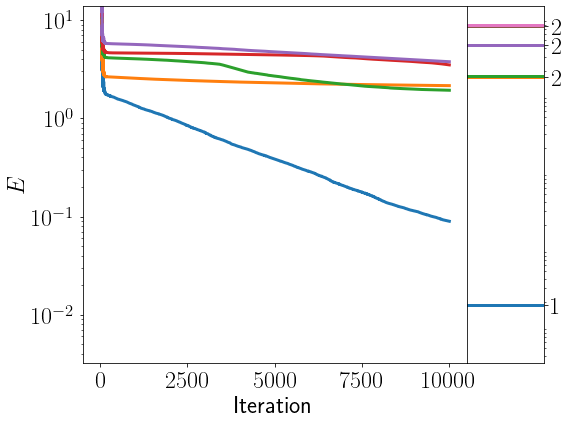

In [37]:
counts1=copy.deepcopy(counts)
values1=copy.deepcopy(values)
steps1=copy.deepcopy(steps)
k1=copy.deepcopy(k)
betas1=copy.deepcopy(betas)
result1=copy.deepcopy(result)


fig = plt.figure() 
fig.set_figheight(6)
fig.set_figwidth(8)
gs = fig.add_gridspec(1,2,wspace=0,width_ratios=[5,1])

(ax1, ax2) = gs.subplots(sharey=False)

counts1=np.asarray(counts1)
steps1=np.asarray(steps1)
values1=np.asarray(values1)
for i in range(1,k+1):
    _counts1=counts1[np.where(steps1==i)]
    _values1=values1[np.where(steps1==i)]
    ax1.plot(_counts1,_values1,label=r'$E_{{{}}}$'.format(i))
ax1.set_xlabel(r'Iteration')
ax1.set_ylabel(r'$E$')
ax1.set_ylim(3.2*1E-3,13.8)
ax1.set_yscale('log')
#plt.legend(loc='upper right')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i,e in enumerate(ens):
    ax2.axhline(e, color=colors[i%len(colors)])
ax2.set_xticks([])
ax2.set_yscale('log')
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks_position("right")
ax2.yaxis.set_ticks([ens[0],ens[1],ens[3],ens[5]], labels=[r"$1$",r"$2$",r"$2$",r"$2$"])
ax2.set_ylim(3.2*1E-4,13.8)

plt.savefig('Plots/aho_vqd.pdf')